In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


# force GPU device
os.environ["CUDA_VISIBLE_DEVICES"]='1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout
from keras import Sequential, Input
from keras.optimizers import Adam
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

In [2]:
max_sequence_length = 100

In [3]:
checkpoint_path = f'saves/rnn/{max_sequence_length}_stratifiedsplit3'
model_path = f'{checkpoint_path}/model.keras'
log_path = f'{checkpoint_path}/log.csv'
history_path = f'{checkpoint_path}/history.npy'

# ensure directory exists
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

load data from csv

In [4]:
data_directory = '/home/jrosendahl/datasets/cadets/sequences_export/'

data = []

labels = None
no_labels = None

distinct_features = [
'EVENT_ACCEPT', 'EVENT_BIND', 'EVENT_CHANGE_PRINCIPAL', 'EVENT_CLOSE', 'EVENT_CONNECT', 'EVENT_CREATE_OBJECT', 'EVENT_EXECUTE', 'EVENT_EXIT', 'EVENT_FCNTL', 'EVENT_FORK', 'EVENT_LINK', 'EVENT_LOGIN', 'EVENT_LSEEK', 'EVENT_MMAP', 'EVENT_MODIFY_FILE_ATTRIBUTES', 'EVENT_MODIFY_PROCESS', 'EVENT_MPROTECT', 'EVENT_OPEN', 'EVENT_OTHER', 'EVENT_READ', 'EVENT_RECVFROM', 'EVENT_RECVMSG', 'EVENT_RENAME', 'EVENT_SENDMSG', 'EVENT_SENDTO', 'EVENT_SIGNAL', 'EVENT_TRUNCATE', 'EVENT_UNLINK', 'EVENT_WRITE', 
]

# distinct_features = [ x[6:] for x in distinct_features ]
no_features = len(distinct_features)
print(f'Found {no_features} distinct features')

count = 0
count_long_sequences_splitted = 0
count_long_sequences_splitted_result = 0

for file_name in os.listdir(data_directory):
    count += 1
    if count % 50000 == 0:
        print(f'Loaded {count} sequences')
    with open(data_directory + file_name, 'r') as f:
        if file_name.count('_') == 2:
            label, _, _ = file_name.split('_')
        elif file_name.count('_') == 3:
            # pwd_mkdb
            label, tmp, _, _ = file_name.split('_')
            label += '_' + tmp
        else:
            print(f'Unknown file name format: {file_name}')
        #label = file_name.split('_')[0]

        # build dictionary with counts of events
        lines = f.readlines()
        # if sequence is longer than max_sequence_length, split into multiple sequences
        if len(lines) > max_sequence_length:
            count_long_sequences_splitted += 1
            for i in range(0, len(lines), max_sequence_length):
                count_long_sequences_splitted_result += 1
                datapoints = []
                for event in lines[i:i+max_sequence_length]:
                    event = event.strip()
                    datapoints.append(distinct_features.index(event))
                data.append((label, datapoints))
        else:
            datapoints = []
            for event in lines:
                event = event.strip()
                datapoints.append(distinct_features.index(event))
            data.append((label, datapoints))

print(f'Loaded {len(data)} sequences')
print(f'Found {count_long_sequences_splitted} sequences longer than max_sequence_length ({max_sequence_length})')
print(f'Split them into {count_long_sequences_splitted_result} sequences')

print(f'Left with {len(data)} datapoints')

random.seed(42)
random.shuffle(data)
labels = [ x[0] for x in data ]
data = [ x[1] for x in data ]

Found 29 distinct features
Loaded 50000 sequences
Loaded 100000 sequences
Loaded 150000 sequences
Loaded 200000 sequences
Loaded 250000 sequences
Loaded 300000 sequences
Loaded 350000 sequences
Loaded 400000 sequences
Loaded 757987 sequences
Found 50088 sequences longer than max_sequence_length (100)
Split them into 376180 sequences
Left with 757987 datapoints


In [5]:
distinct_labels = np.unique(np.array(labels))
no_labels = len(distinct_labels)
print(f'Found {no_labels} distinct labels')

# get distinct features
print(f'Found {no_features} distinct features')

# encode labels from strings to integers to one-hot
# labels = np.eye(no_labels)[np.vectorize(distinct_labels.tolist().index)(labels)]
# encode labels to integers
labels = np.vectorize(distinct_labels.tolist().index)(labels)
print(f'Encoded labels to integers')
# encode labels to one-hot
labels = np.eye(no_labels)[labels]
print(f'Encoded labels to one-hot')

# encode sequences from list of integers to list of one-hot
data = [ np.eye(no_features)[x] for x in data ]
print(f'Encoded sequences to one-hot')

# get pad event to pad sequences with when batches are built
pad_event = np.zeros(no_features)

Found 135 distinct labels
Found 29 distinct features
Encoded labels to integers
Encoded labels to one-hot
Encoded sequences to one-hot


prepare data + generator

In [6]:
# statified split with duplication of rare classes (duplication only in training set)
rare_threshold = 50

# identify rare classes in data
rare_classes = []
for i in range(no_labels):
    count = np.sum(np.argmax(labels, axis=1) == i)
    if count < rare_threshold:
        rare_classes.append(i)

print(f'Found {len(rare_classes)} rare classes')

# separate rare classes from data
rare_data = []
rare_labels = []
common_data = []
common_labels = []

for i in range(len(labels)):
    if np.argmax(labels[i]) in rare_classes:
        rare_data.append(data[i])
        rare_labels.append(labels[i])
    else:
        common_data.append(data[i])
        common_labels.append(labels[i])

print(f'Separated {len(rare_data)} rare samples and {len(common_data)} common samples')

# split into training, validation and testing (70/15/15) using stratified split

X_train, X_val, y_train, y_val = train_test_split(common_data, common_labels, test_size=0.3, stratify=common_labels)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

print(f'set sized before adding back rare classes: {len(X_train)}, {len(X_val)}, {len(X_test)}')

# add back rare classes to validation and testing
X_val += rare_data
y_val += rare_labels
X_test += rare_data
y_test += rare_labels

# duplicate rare classes until they are not rare anymore
while len(rare_data) < len(common_data):
    rare_data += rare_data
    rare_labels += rare_labels

# add duplicated rare classes to training
X_train += rare_data
y_train += rare_labels

print(f'Training on {len(X_train)} samples')
print(f'Validating on {len(X_val)} samples')
print(f'Testing on {len(X_test)} samples')

# check how many labels are not present in sets
train_labels = set(np.argmax(y_train, axis=1))
val_labels = set(np.argmax(y_val, axis=1))
test_labels = set(np.argmax(y_test, axis=1))

total_labels = set(range(no_labels))

# print which labels do not occur in which set
print(f'Labels not in training: {total_labels - train_labels}')
print(f'Labels not in validation: {total_labels - val_labels}')
print(f'Labels not in testing: {total_labels - test_labels}')


Found 66 rare classes
Separated 743 rare samples and 757244 common samples
set sized before adding back rare classes: 530070, 113587, 113587
Training on 1290902 samples
Validating on 114330 samples
Testing on 114330 samples
Labels not in training: set()
Labels not in validation: set()
Labels not in testing: set()


In [7]:
class Generator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size, fixed_length, **kwargs):
        # valid **kwargs: workers, use_multiprocessing, max_queue_size
        super().__init__()
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.fixed_length = fixed_length
        self.no_samples = len(X)
        self.no_batches = int(np.ceil(self.no_samples / self.batch_size))

    def __len__(self):
        return self.no_batches

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, self.no_samples)

        # Get the batch data
        X_batch = self.X[start:end]
        y_batch = self.y[start:end]

        # Pad or truncate each sequence in X_batch to the fixed length
        X_batch_fixed = [self._pad_or_truncate(x, self.fixed_length) for x in X_batch]

        # Convert to numpy arrays
        X_batch_fixed = np.array(X_batch_fixed)
        y_batch = np.array(y_batch)

        return X_batch_fixed, y_batch

    def _pad_or_truncate(self, sequence, length):
        if len(sequence) < length:
            # Pad sequence with zeros to the fixed length
            return np.pad(sequence, ((0, length - len(sequence)), (0, 0)), mode='constant', constant_values=0)
        else:
            # Truncate sequence to the fixed length
            return sequence[:length]

    def on_epoch_end(self):
        pass

build model

In [ ]:
model = Sequential(layers=[
    Input(shape=(None, no_features)),
    SimpleRNN(96, return_sequences=True),
    SimpleRNN(96, return_sequences=True),
    SimpleRNN(96, return_sequences=False),
    Dense(no_labels, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 96)       │        12,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 96)       │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 96)             │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 135)            │        13,095 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,247 (243.15 KB)

 Trainable params: 62,247 (243.15 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    verbose=1,
    mode='auto'
)

model_checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_schedule = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-7
)

csv_logger = CSVLogger(
    filename=log_path,
    append=True
)

optimizer = Adam(learning_rate=0.0001)


# 'categorical_focal_crossentropy'
# 'categorical_crossentropy'
model.compile(optimizer=optimizer, loss='categorical_focal_crossentropy', metrics=['accuracy'])

train model

In [8]:
# load old model
model = load_model(model_path)

In [ ]:
history = model.fit(
    x=Generator(X_train, y_train, 96, max_sequence_length),
    validation_data=Generator(X_val, y_val, 96, max_sequence_length),
    epochs=200,
    callbacks=[early_stop, model_checkpoint, lr_schedule, csv_logger],
)

# save history to file
with open(history_path, 'wb') as f:
    np.save(f, history.history)

In [ ]:
# load history from file
history = np.load(history_path, allow_pickle=True).item()

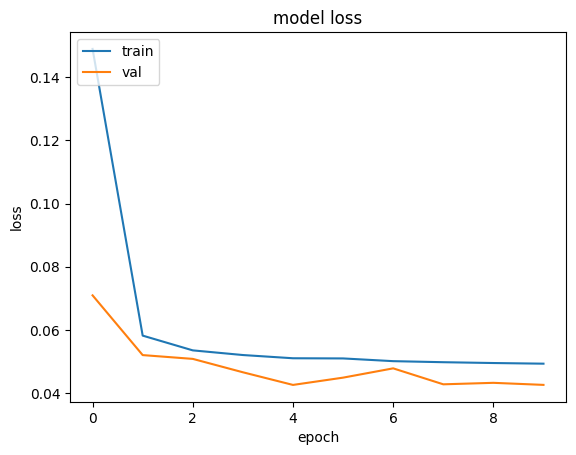

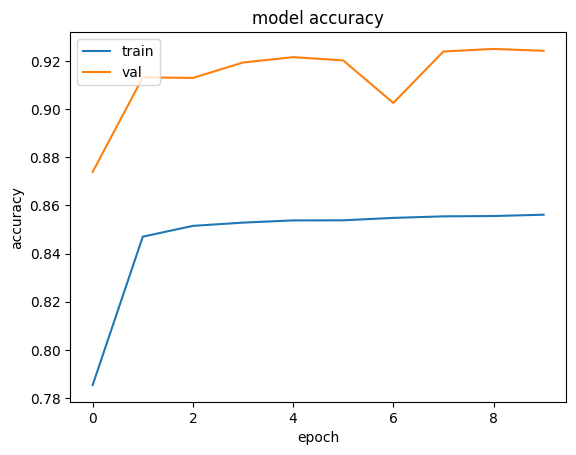

In [13]:
# plot history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

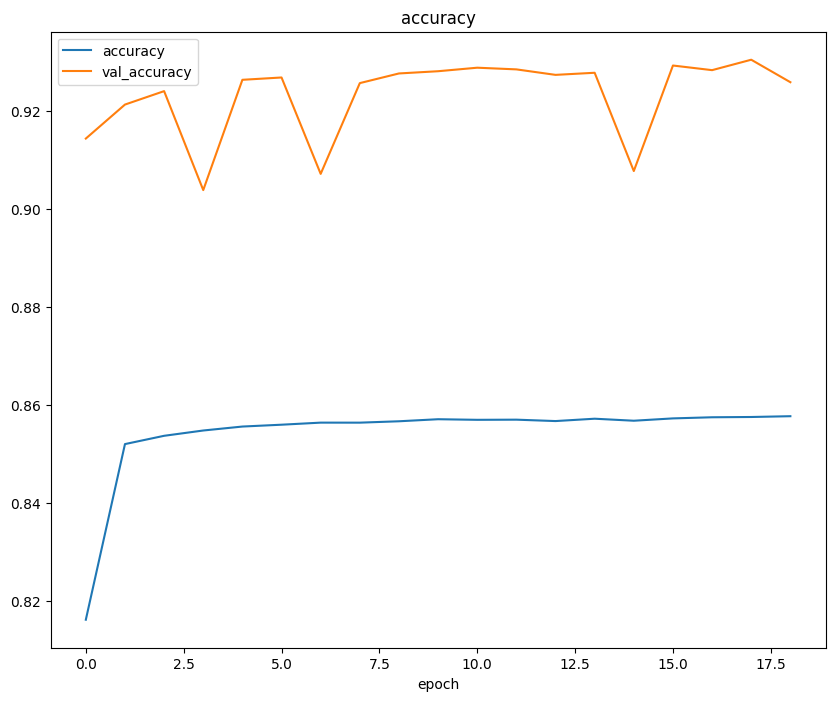

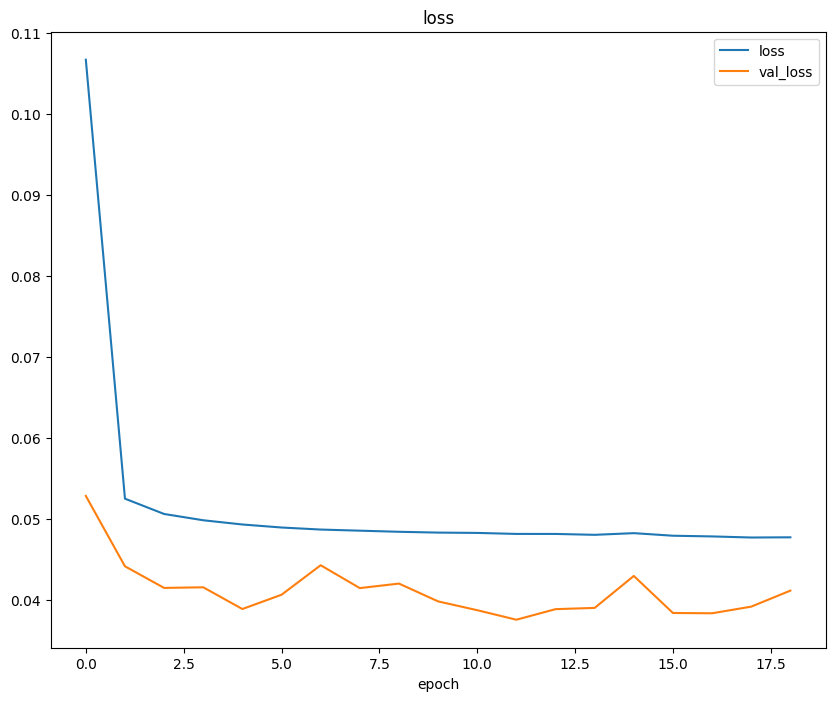

In [9]:
log = pd.read_csv(log_path)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(log['epoch'], log['accuracy'], label='accuracy')
ax.plot(log['epoch'], log['val_accuracy'], label='val_accuracy')
ax.set_title('accuracy')
ax.set_xlabel('epoch')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(log['epoch'], log['loss'], label='loss')
ax.plot(log['epoch'], log['val_loss'], label='val_loss')
ax.set_title('loss')
ax.set_xlabel('epoch')
ax.legend()

plt.show()

In [10]:
# evaluate model
score = model.evaluate(x=Generator(X_test, y_test, 64, max_sequence_length))
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

I0000 00:00:1721569212.124560 1404062 service.cc:145] XLA service 0x193fca80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721569212.124628 1404062 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5


  13/1787 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9179 - loss: 0.0431

I0000 00:00:1721569212.660348 1404062 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1787/1787 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.9292 - loss: 0.0373
Test loss: 0.03678712621331215
Test accuracy: 0.9292749166488647


In [11]:
# print classification report
y_pred = model.predict(x=Generator(X_test, y_test, 64, max_sequence_length))
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred))

1787/1787 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step
              precision    recall  f1-score   support

           0       0.40      0.89      0.55         9
           1       0.00      0.00      0.00        20
           2       0.74      0.65      0.69       851
           3       0.86      0.45      0.59       598
           4       1.00      1.00      1.00       467
           5       1.00      0.88      0.93         8
           6       0.00      0.00      0.00        11
           7       0.95      0.97      0.96     24455
           8       0.01      1.00      0.02        13
           9       0.32      1.00      0.48        41
          10       0.94      1.00      0.97        15
          11       0.92      0.90      0.91        51
          12       1.00      1.00      1.00        11
          13       0.50      1.00      0.67         1
          14       1.00      1.00      1.00         1
          15       0.97      0.47      0.63       666
          16       1.00      1.00   

/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

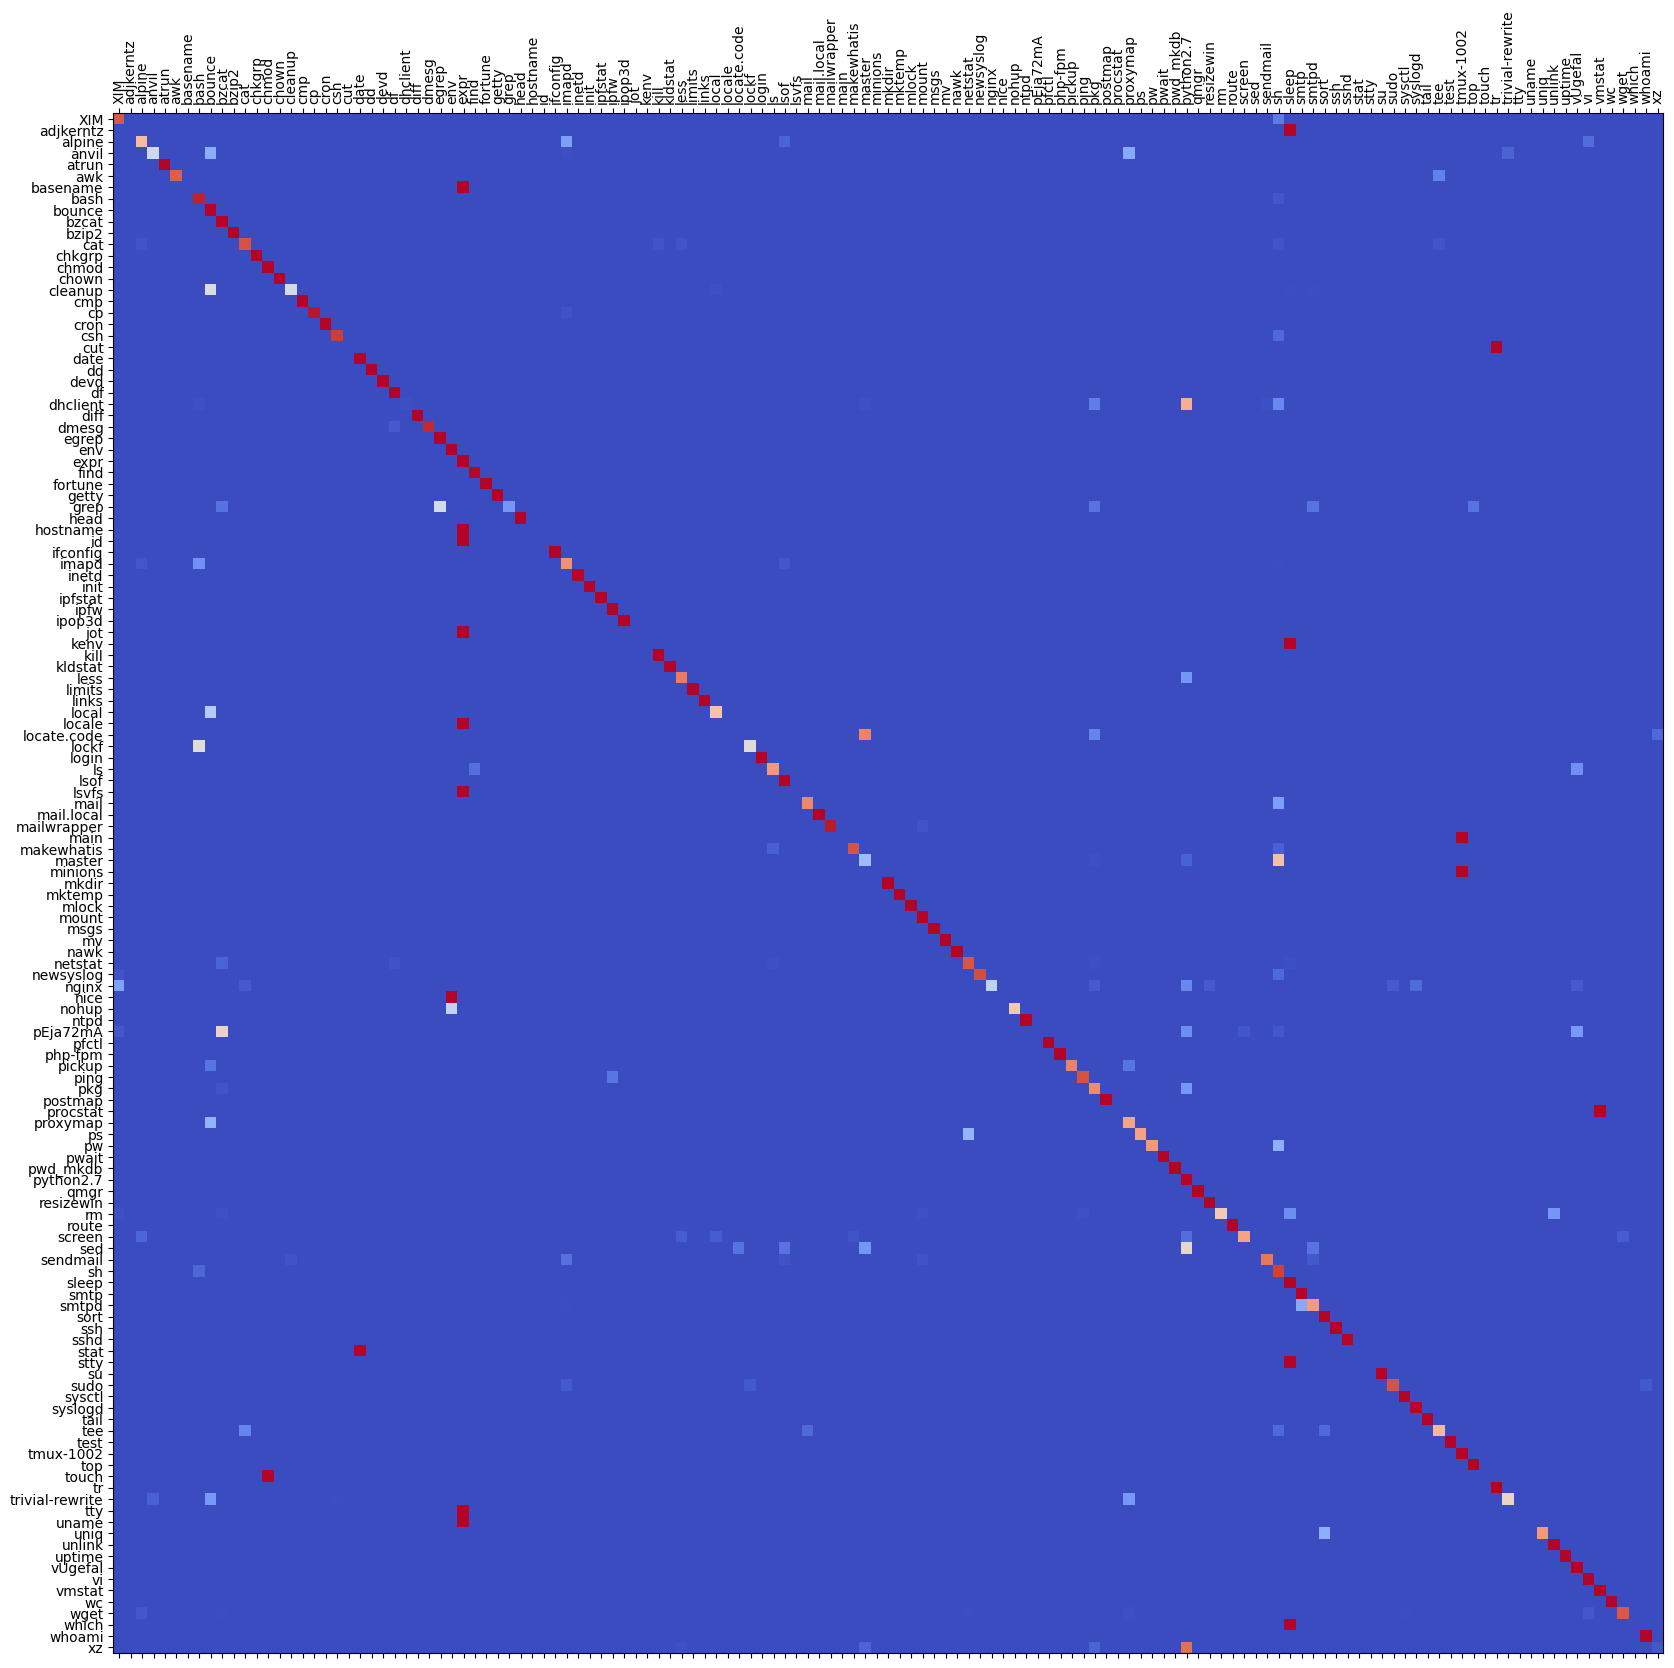

In [12]:
# print confusion matrix
# labels explicitly set, because current model may not predict all labels
cm = confusion_matrix(y_true, y_pred, labels=range(no_labels))

# transform to percentage
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# replace all NaN values with 0
cm = np.nan_to_num(cm)

fig, ax = plt.subplots(figsize=(20, 20))

ax.matshow(cm, cmap='coolwarm', aspect='auto')

# Set class names on axes
ax.set_xticks(range(len(distinct_labels)))
ax.set_yticks(range(len(distinct_labels)))
ax.set_xticklabels(distinct_labels, rotation=90)
ax.set_yticklabels(distinct_labels)

plt.show()